# XGBoost for BACtrack Data

In [43]:
import os
import logging
import datetime as dt
import pandas as pd
import numpy as np
import h5py
import itertools
import sys
import cloudpickle

import pyarrow as pa
import pyarrow.parquet as pq

# Might need to go before xgboost imports
import importlib
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import xgboost as xgb
from sklearn.metrics import accuracy_score, average_precision_score, roc_auc_score, auc, roc_curve, \
    confusion_matrix, classification_report
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
%matplotlib inline
%config Application.log_level="INFO"

In [44]:
logging.basicConfig(format='%(asctime)s | %(levelname)s : %(message)s',
                     level=logging.INFO, stream=sys.stdout)

logging.info('Hello world!')

2019-06-10 13:52:44,469 | INFO : Hello world!


#### GLOBAL VARIABLES AND SETTINGS

In [45]:
# Secure-copy updated data to server: 
# scp $LOCAL_PATH kaschbacher@tisoncluster.ucsf.edu:$SERVER_PATH

In [78]:
DATA_FOLDER = 'data'
FIGURE_FOLDER = 'figures'
#FILENAME = 'bac_2018-11-27.h5'
FILENAME = 'bac_2019-06-10.parquet'
PATH = '/'.join([DATA_FOLDER, FILENAME])
TODAY = str(dt.date.today())
MISSING_VALUE = np.nan

In [107]:
SEED = 11
TRAIN_P = .70
DEV_P = .10
TEST_P = 1 - TRAIN_P - DEV_P
split_percents = [TRAIN_P, DEV_P, TEST_P]

In [108]:
DEFAULT_BOOSTING_PARAMS = {
    'silent':1,
    'learning_rate':.3,
    'max_depth':6,
    'min_child_weight':1,# default=1, larger=more conservative; building process will give up partitioning 
    'subsample':0.80,
    'colsample_bytree':0.80,
    'objective':'binary:logistic',#'objective':'binary:logistic' or 'reg:linear'
    'num_boost_round': 10,
    #'eval_metric':'auc',
    'random_state':7,
    'lambda':1,# default=1, L2 (ridge); higher values = more conservative
    'alpha':0,# default=0, L1 (lasso); higher values = more conservative
    'gamma':0,# [default=0, alias: min_split_loss] - Larger=more conservative. Minimum loss reduction required to make a further partition on a leaf node of the tree
    'scale_pos_weight':1# default=1, reset later based on class distribution
}

In [109]:
# Starts with defaults, but can change
boosting_params = DEFAULT_BOOSTING_PARAMS

In [110]:
# Set Parameters for Grid Search
def get_gs_params(params):
    gs_params = {
        'learning_rate': params['learning_rate'], 
        'num_boost_round': params['num_boost_round'],
        #'n_estimators': best_n_estimators, 
        'max_depth': params['max_depth'],
        'min_child_weight': params['min_child_weight'], 
        'gamma': params['gamma'], 
        'subsample': params['subsample'], 
        'colsample_bytree': params['colsample_bytree'], 
        'return_train_score': True,
        'objective': 'binary:logistic', 
        #'n_jobs': 4,# -1 --> make use of all the cores in your system; but supposedly could also slow things 
        'scale_pos_weight':params['scale_pos_weight'], 
        'seed':7
    }
    return gs_params

In [111]:
figure_params = {
    'figure.figsize':(5,5),
    'figure.titlesize':20,
    'xtick.labelsize': 13,
    'ytick.labelsize': 13,
    'axes.labelsize': 18
}

#### Load Data

In [112]:
def load_data(path):
    df = pq.read_table(path, use_threads=4).to_pandas()
    names = df.columns.tolist()
    data = df.values
    return names, data

#### Randomly Shuffle the rows
--- so that there is no systematic association of date with train/val/test

In [113]:
def shuffle_rows(data, SEED):
    # shuffles rows of an np-array, w/ seed, order will always be replicable
    np.random.seed(seed=SEED)
    np.random.shuffle(data)
    return data

#### Option to partition by observation --> train/dev/test

In [114]:
def partition_by_observation(split_percents, data, idx_uid):
    train_per, dev_per, test_per = split_percents
    m = data.shape[0]
    train, dev, test = np.split(data, [int(m*train_per), int(m*(train_per+dev_per))]) 
    print ('train shape: {}, dev shape: {}, test shape: {}'.format(train.shape, dev.shape, test.shape))
    assert train.shape[0] + dev.shape[0] + test.shape[0] == data.shape[0]
    
    # Assumes y or target outcome is the first column, and that all other columns will be included in X
    # Omit user_id in column 1
    if idx_uid!=1: print ('Error: Expected user id in column 1, in function partition by observation')
    partitions = {}
    partitions['X_train'] = train[:,2:]
    partitions['y_train'] = train[:,0]
    partitions['X_dev'] = dev[:,2:]
    partitions['y_dev'] = dev[:,0]
    partitions['X_test'] = test[:,2:]
    partitions['y_test'] = test[:,0]
    
    return partitions

#### Option to Partition by User
<p> -- dev and test set will not share any users with train set. No learning possible about individual users </p>

In [115]:
def get_unique_uids(data):
    # Get unique user ids
    user_ids = np.unique(data[:,1])
    print ('Number of unique users: {}'.format(user_ids.shape[0]))
    #np.random.shuffle(user_ids)# Not needed because I already shuffled observations
    return user_ids

In [116]:
def partition_users(users, split_percents):
    train_per, dev_per, test_per = split_percents
    s = len(users)
    arys = np.split(users, [int(train_per*s), int((train_per+dev_per)*s)])
    return arys[0], arys[1], arys[2]

In [117]:
def get_idx(uuids, idx_uid):
    # given a list of user ids, find the indices in the data np-ary that represent observations from these users
    idx = []
    for ui in uuids:
        temp = np.where(data[:, idx_uid]==ui)[0]
        idx = np.append(idx, temp, axis=0).astype(int)
    return idx

In [118]:
def partition_by_user(split_percents, data, idx_uid):
    # Get arrays of user_ids that partition up the train, dev, test
    uuids = get_unique_uids(data)# returns a randomly shuffled array of unique user ids
    train_ui, dev_ui, test_ui = partition_users(uuids, split_percents)
    assert len(uuids) == train_ui.shape[0] + dev_ui.shape[0] + test_ui.shape[0]

    # Get the indices for the observations belonging to a given set of user_ids

    partitions={}
    segments = {'train': train_ui, 'dev': dev_ui, 'test': test_ui}
    for k, uuids in segments.items():
        print ('Running segment: {}...'.format(k))
        %time
        idx = get_idx(uuids, idx_uid)
        idx = np.sort(idx)
        partitions['X_'+k]=data[idx, 2:]
        partitions['y_'+k]=data[idx, 0]
    print ('train shape: {}, dev shape: {}, test shape: {}'.format(partitions['X_train'].shape, partitions['X_dev'].shape, partitions['X_test'].shape))
        
    return partitions

#### Package Data Matrices for XGBoost

In [119]:
def package_data (partitions, names, idx_uid):
    # Assign data - (Note: must dropna first, otherwise missing=-999 throws an error because NaNs also still exist)
    print ("\nSetting up data-matrices for Gradient Boosted Classification Tree with Outcome: {}...\n".format(names[0]))

    names = [str(name) for name in names]# convert from byte to string
    del names[idx_uid]# Omit user_id at idx, 1
    partitions['names']=names
    partitions['dtrain'] = xgb.DMatrix(data=partitions['X_train'], label=partitions['y_train'], 
                                       feature_names=names[1:], missing=MISSING_VALUE)
    partitions['ddev'] = xgb.DMatrix(data=partitions['X_dev'], label=partitions['y_dev'], 
                                     feature_names=names[1:], missing=MISSING_VALUE)
    partitions['dtest'] = xgb.DMatrix(data=partitions['X_test'], label=partitions['y_test'], 
                                      feature_names=names[1:], missing=MISSING_VALUE)
    
    return partitions

#### Balance Classes

In [120]:
def get_balance_weight(y_train):

    pos = np.sum(y_train, axis=0, dtype=int)
    neg = y_train.shape[0]-pos
    print ('\n{} positive cases and {} negative cases'.format(pos, neg))

    scale_pos_weight = round(neg/pos, 2)# 2.38 for the BACtrack dataset
    print ('Scale Weight for balanced classes would be: {}'.format(scale_pos_weight))
    return scale_pos_weight

#### Training/Fitting the Model
--- fit vs train -- https://datascience.stackexchange.com/questions/17282/xgbregressor-vs-xgboost-train-huge-speed-difference

In [121]:
def fit_model(dtrain, ddev, boosting_params):
    # # Training a Model
    # # -- xgboost.train will ignore parameter n_estimators, while xgboost.XGBRegressor accepts. 
    # # -- In xgboost.train, boosting iterations (i.e. n_estimators) is controlled by num_boost_round(default: 10)
    # # -- the learning_rate (eta) and num_boost_rounds are instrisincally connected.  
    # # -- Slower learning rates will typically require more rounds

    # if num_boost_round not explicitly given as kwarg, it will be overridden by default of 10, which can be seen in eval printing
    watchlist = [(ddev, 'dev'), (dtrain, 'train')]
    %time
    model = xgb.train(params=boosting_params, dtrain=dtrain, evals=watchlist, verbose_eval=True,
                      num_boost_round=boosting_params['num_boost_round'])# try predictor='gpu_predictor'
    return model

#### Make & Evaluate Model Predictions

In [122]:
def predict(model, d_true):
    # d_true is the xgboost prepared dataset corresponding to test or dev (per needs); includes X and y and names
    y_proba = model.predict(d_true)
    y_pred = [round(value) for value in y_proba]# Use to get 0 vs 1?
    return y_pred, y_proba

In [123]:
def evaluate_model(y_true, y_pred, y_proba):
    accuracy = accuracy_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_proba, average='micro', max_fpr=None)#sample_weight=scale_pos_weight, 
    print ('Accuracy: {:02.2f}%'.format(accuracy*100.))
    print ('ROC AUC: {:02.2f}%'.format(roc_auc*100.))
    return accuracy, roc_auc

#### Confusion Matrix

In [124]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix\n")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Actual')
    plt.xlabel('Predicted')

#### Full Report (w/ Confusion Matrix)

In [125]:
def full_report(figure_params, y_test, y_pred, target_names):
    
    # # Plot Confusion Matrix for Classification - http://scikit-learn.org/stable/modules/model_evaluation.html
    plt.rcParams.update(figure_params)

    cnf_matrix = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    fig = plt.figure()
    plot_confusion_matrix(cnf_matrix, ['low BAC','high BAC'], normalize=True)
    plt.title('Confusion Matrix', fontsize=16)
    plt.show()
    fig.savefig('/'.join( \
        [FIGURE_FOLDER,'/cm/Normalized_Confusion_Matrix_BAC_Classification_{}.png'.format(TODAY)]), \
        bbox_inches='tight')

    # Classification Report
    #print ('\nAccuracy: {:02.2f}%\n'.format(accuracy*100.))
    print (classification_report(y_test, y_pred, target_names=target_names),'\n')

### Plot ROC

In [126]:
def plot_ROC(y_test, y_pred_proba):
    # y_test can also be y_dev, depending on context
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # Calculate x and y for ROC-curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    #print (fpr.shape, tpr.shape, roc_auc)# DEBUG

    #Plot of a ROC curve for a specific class
    plt.rcParams.update(figure_params)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange',
             lw=2, label='ROC curve (area = {:0.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

### Built-in Feature Importance Graph:  
--- importance_type='weight' matches above.  'cover' provides quite different results, which may be of interest to report in paper.

In [127]:
def graph_importances(model):  
    
    # -- http://xgboost.readthedocs.io/en/latest/python/python_api.html
    # weight” is the number of times a feature appears in a tree “gain” is the average gain of splits which use the feature...
    # “cover” is the average coverage of splits which use the feature, where coverage is defined as the number of samples affected by the split
    plt.rcParams['figure.figsize']=(14,18)
    xgb.plot_importance(model, importance_type='weight')
    plt.title('Feature Importance (Weight)', fontsize=20)
    plt.show()
    plt.savefig('/'.join([FIGURE_FOLDER,'fi/feature_importance_{}.png'.format(TODAY)]), \
                bbox_inches='tight')   

### MAIN

In [128]:
%%time
# Load Data
names, data = load_data(PATH)
print (data.shape, '\n')# QA
print (names[:3])# Ensure that bac_clinical (or the outcome) is the first column!

/home/kaschbacher/.conda/envs/bactrack/lib/python3.6/site-packages/pyarrow/pandas_compat.py:708: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels = getattr(columns, 'labels', None) or [
/home/kaschbacher/.conda/envs/bactrack/lib/python3.6/site-packages/pyarrow/pandas_compat.py:735: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  return pd.MultiIndex(levels=new_levels, labels=labels, names=columns.names)
/home/kaschbacher/.conda/envs/bactrack/lib/python3.6/site-packages/pyarrow/pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


(973264, 90) 

['bac_clinical', 'user_id', 'bac_guess']
CPU times: user 8.92 s, sys: 7.99 s, total: 16.9 s
Wall time: 3 s


#### Prepare Data

In [129]:
%%time
# Partition randomly
shuffle_rows(data, SEED)

CPU times: user 4.68 s, sys: 144 ms, total: 4.83 s
Wall time: 3.27 s


array([[0.00000000e+00, 7.11200000e+03, 0.00000000e+00, ...,
        2.50000000e+01, 1.90000000e+00, 1.00000000e+00],
       [0.00000000e+00, 1.04970000e+04, 3.99999991e-02, ...,
                   nan,            nan,            nan],
       [0.00000000e+00, 2.43700000e+03, 2.99999993e-02, ...,
                   nan,            nan,            nan],
       ...,
       [1.00000000e+00, 3.11940000e+04, 9.00000036e-02, ...,
        4.80000000e+02, 5.40000000e+00, 1.00000000e+00],
       [0.00000000e+00, 2.02670000e+04, 1.99999996e-02, ...,
        3.80000000e+01, 1.30000000e+00, 1.00000000e+00],
       [1.00000000e+00, 1.10320000e+04, 0.00000000e+00, ...,
        9.00000000e+00, 9.00000000e-01, 1.00000000e+00]])

#### Partition data in 1 of 2 ways - (by randomly assigning either observations or users to the train/dev/test)

### Balancing the Classes/ Determining Class Weights

In [130]:
def balance_classes(params, partitions):
    prior_scale_pos_weight = params['scale_pos_weight']
    # Reset scale weight in boosting params and in the grid search params both
    params['scale_pos_weight'] = get_balance_weight(partitions['y_train'])
    print ('\nResetting positive scale weight from {} to {}...\n'.format(prior_scale_pos_weight, params['scale_pos_weight']))
    return params

In [131]:
def print_parameters(param_type, params):
    print ('\n\n{} parameters...\n'.format(param_type),'-'*20,'\n')
    for k, p in params.items():
        print (k, p)
    print ('\n\n')

## Default Model for Comparison

In [155]:
def base_model_wwo_balancing(boosting_params, partitions):
    
    def set_params_to_default(params):
        # QA code - ensure correct state of params
        # Assumption is that boosting_params starts out at the default, and then can be altered throughout the tuning process
        if params != DEFAULT_BOOSTING_PARAMS:
            print ('Resetting boosting params to be equal to DEFAULT\n')
            params = DEFAULT_BOOSTING_PARAMS
        # Assumes we start with no scale weighting, and compare that to weighting inversely to case prevalence in the training set
        if params['scale_pos_weight'] != 1:
            print ('Converting the scale weight for boosting params back to 1 for the first run...\n')
            params['scale_pos_weight'] = 1
        print_parameters('Default boosting parameters', params)
        return params
    
    
    boosting_params = set_params_to_default(boosting_params)
    
    # Fit & Evaluate model twice: 1) Unbalanced, 2) Balanced
    for i in range(0,2):
        if i>0: 
            print ('-'*60,'\n')
            boosting_params = balance_classes(boosting_params, partitions)
            
        # Fit Model
        print ('Run {}, Scale weight = {:0.2f}'.format(i, boosting_params['scale_pos_weight']))
        model= fit_model(partitions['dtrain'], partitions['ddev'], boosting_params)

        # Predict/ Evaluate in Dev set
        y_true = partitions['y_dev']; d_true = partitions['ddev']
        y_pred, y_proba = predict(model, d_true)
        accuracy, roc = evaluate_model(y_true, y_pred, y_proba)

        # Get Results & Figures
        plot_ROC(y_true, y_proba)
        full_report(figure_params, y_true, y_pred, ['bac <.08', 'bac >=.08'])
        #graph_importances(model) 
        

### First, partition by randomly assigned users

Number of unique users: 33460
Running segment: train...
CPU times: user 596 µs, sys: 49 µs, total: 645 µs
Wall time: 55.3 µs
Running segment: dev...
CPU times: user 11 µs, sys: 0 ns, total: 11 µs
Wall time: 23.6 µs
Running segment: test...
CPU times: user 9 µs, sys: 1e+03 ns, total: 10 µs
Wall time: 17.9 µs
train shape: (893983, 88), dev shape: (37710, 88), test shape: (41571, 88)

Setting up data-matrices for Gradient Boosted Classification Tree with Outcome: bac_clinical...

Converting the scale weight for boosting params back to 1 for the first run...



Default Boosting parameters parameters...
 -------------------- 

silent 1
learning_rate 0.3
max_depth 6
min_child_weight 1
subsample 0.8
colsample_bytree 0.8
objective binary:logistic
num_boost_round 10
random_state 7
lambda 1
alpha 0
gamma 0
scale_pos_weight 1



Run 0, Scale weight = 1.00
CPU times: user 10 µs, sys: 0 ns, total: 10 µs
Wall time: 21.9 µs
[0]	dev-error:0.302917	train-error:0.202914
[1]	dev-error:0.301962	train-erro

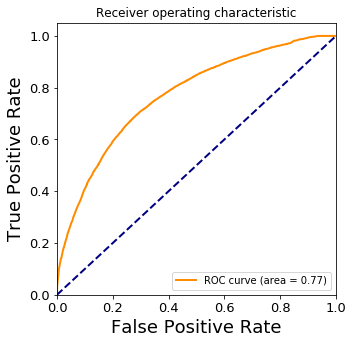

Normalized confusion matrix

[[0.74673732 0.25326268]
 [0.33870037 0.66129963]]


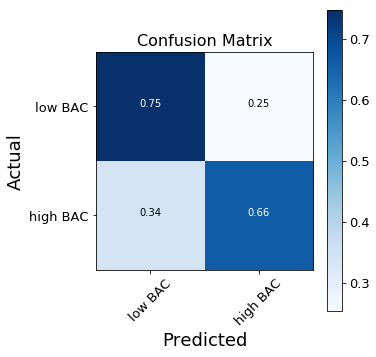

              precision    recall  f1-score   support

    bac <.08       0.72      0.75      0.73     20382
   bac >=.08       0.69      0.66      0.68     17328

   micro avg       0.71      0.71      0.71     37710
   macro avg       0.71      0.70      0.70     37710
weighted avg       0.71      0.71      0.71     37710
 

------------------------------------------------------------ 


250229 positive cases and 643754 negative cases
Scale Weight for balanced classes would be: 2.57

Resetting positive scale weight from 1 to 2.57...

Run 1, Scale weight = 2.57
CPU times: user 10 µs, sys: 0 ns, total: 10 µs
Wall time: 19.6 µs
[0]	dev-error:0.359056	train-error:0.259386
[1]	dev-error:0.364254	train-error:0.256203
[2]	dev-error:0.363538	train-error:0.251916
[3]	dev-error:0.361283	train-error:0.250715
[4]	dev-error:0.362371	train-error:0.250742
[5]	dev-error:0.360249	train-error:0.248001
[6]	dev-error:0.360355	train-error:0.245849
[7]	dev-error:0.362132	train-error:0.246004
[8]	dev-error

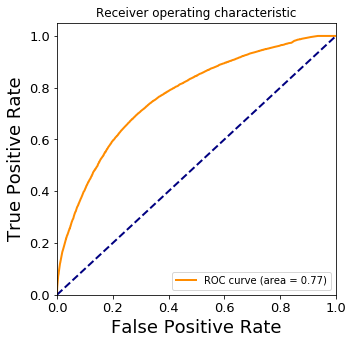

Normalized confusion matrix

[[0.44956334 0.55043666]
 [0.12690443 0.87309557]]


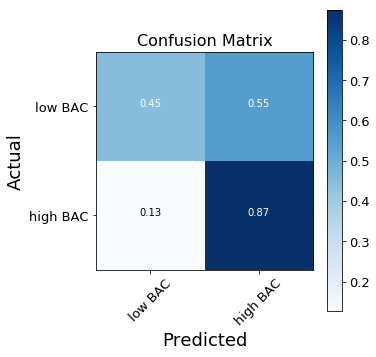

              precision    recall  f1-score   support

    bac <.08       0.81      0.45      0.58     20382
   bac >=.08       0.57      0.87      0.69     17328

   micro avg       0.64      0.64      0.64     37710
   macro avg       0.69      0.66      0.64     37710
weighted avg       0.70      0.64      0.63     37710
 



In [136]:
# Confirm what column user_id is in
idx_uid = 1
assert names[idx_uid]=='user_id'

partitions = partition_by_user(split_percents, data, idx_uid)
partitions = package_data(partitions, names, idx_uid)# Package data for XGboost (dtrain, dtest, etc)
base_model_wwo_balancing(boosting_params, partitions)

### Contrast results, which partition randomly assigned observations
-- i.e., the same user can have some observations in the training set and the dev set or test set

train shape: (681284, 90), dev shape: (97327, 90), test shape: (194653, 90)

Setting up data-matrices for Gradient Boosted Classification Tree with Outcome: bac_clinical...

Converting the scale weight for boosting params back to 1 for the first run...



Default Boosting parameters parameters...
 -------------------- 

silent 1
learning_rate 0.3
max_depth 6
min_child_weight 1
subsample 0.8
colsample_bytree 0.8
objective binary:logistic
num_boost_round 10
random_state 7
lambda 1
alpha 0
gamma 0
scale_pos_weight 1



Run 0, Scale weight = 1.00
CPU times: user 8 µs, sys: 0 ns, total: 8 µs
Wall time: 19.6 µs
[0]	dev-error:0.21251	train-error:0.212923
[1]	dev-error:0.209017	train-error:0.208572
[2]	dev-error:0.207846	train-error:0.207152
[3]	dev-error:0.207404	train-error:0.206516
[4]	dev-error:0.206202	train-error:0.205575
[5]	dev-error:0.205791	train-error:0.204567
[6]	dev-error:0.205832	train-error:0.204203
[7]	dev-error:0.205441	train-error:0.203733
[8]	dev-error:0.205503	train-error:0

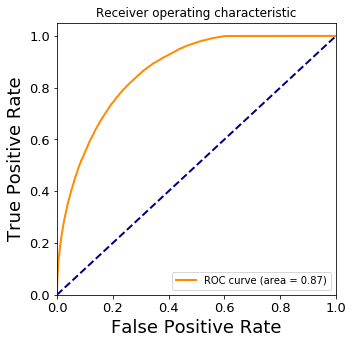

Normalized confusion matrix

[[0.89973364 0.10026636]
 [0.44929135 0.55070865]]


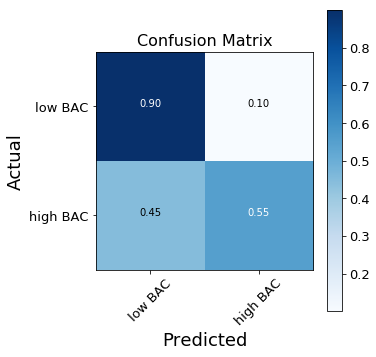

              precision    recall  f1-score   support

    bac <.08       0.83      0.90      0.86     68328
   bac >=.08       0.70      0.55      0.62     28999

   micro avg       0.80      0.80      0.80     97327
   macro avg       0.76      0.73      0.74     97327
weighted avg       0.79      0.80      0.79     97327
 

------------------------------------------------------------ 


201610 positive cases and 479674 negative cases
Scale Weight for balanced classes would be: 2.38

Resetting positive scale weight from 1 to 2.38...

Run 1, Scale weight = 2.38
CPU times: user 13 µs, sys: 1e+03 ns, total: 14 µs
Wall time: 27.7 µs
[0]	dev-error:0.264572	train-error:0.265995
[1]	dev-error:0.256691	train-error:0.258265
[2]	dev-error:0.255315	train-error:0.256839
[3]	dev-error:0.24877	train-error:0.249849
[4]	dev-error:0.250968	train-error:0.253113
[5]	dev-error:0.249283	train-error:0.251209
[6]	dev-error:0.249088	train-error:0.250034
[7]	dev-error:0.249848	train-error:0.251251
[8]	dev-er

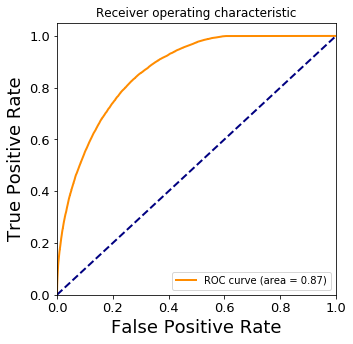

Normalized confusion matrix

[[0.71910491 0.28089509]
 [0.16124694 0.83875306]]


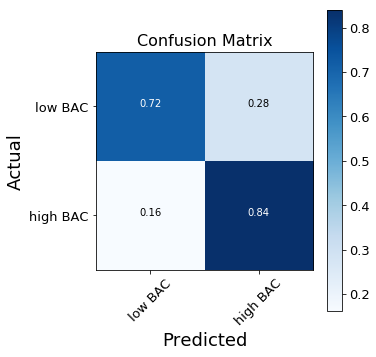

              precision    recall  f1-score   support

    bac <.08       0.91      0.72      0.80     68328
   bac >=.08       0.56      0.84      0.67     28999

   micro avg       0.75      0.75      0.75     97327
   macro avg       0.74      0.78      0.74     97327
weighted avg       0.81      0.75      0.76     97327
 



In [137]:
partitions = partition_by_observation(split_percents, data, idx_uid)
partitions = package_data(partitions, names, idx_uid)# Package data for XGboost (dtrain, dtest, etc)
base_model_wwo_balancing(boosting_params, partitions) 

### Use Cross-Validated XGBoost to determine the optimal number of trees

In [ ]:
%%time

# EVALUATE LEARNING RATE AND MAX_DEPTH TOGETHER
# For learning_rate=1 & max_depth=6 --> optimal number of trees=30
boosting_params['learning_rate']= .01
boosting_params['max_depth']= 6
boosting_params['nthread']=-1
boosting_params['num_boost_round']= 500
boosting_params['verbose']=2
# watchlist = [(partitions['ddev'], 'dev'), (partitions['dtrain'], 'train')]
# boosting_params['evals']=watchlist

print_parameters('Boosting Params', boosting_params)

cvresult = xgb.cv(boosting_params, partitions['dtrain'], num_boost_round=boosting_params['num_boost_round'], \
                 nfold=3, early_stopping_rounds=10, verbose_eval=True, \
                 seed=7, metrics='auc')# metrics=['auc','mae','map']

best_n_estimators = cvresult.shape[0]
print ('\nThe optimal number of trees is {}\n'.format(best_n_estimators))
# optimal trees was 52 with learning rate of 1 and early_stopping=10

Boosting Params...

silent 1
learning_rate 0.01
max_depth 6
min_child_weight 1
subsample 0.8
colsample_bytree 0.8
objective binary:logistic
num_boost_round 500
random_state 7
lambda 1
alpha 0
gamma 0
scale_pos_weight 2.38
nthread -1
verbose 2


[0]	train-auc:0.772994+0.037124	test-auc:0.771706+0.0371879
[1]	train-auc:0.819818+0.0263424	test-auc:0.818489+0.0273702
[2]	train-auc:0.828171+0.0138876	test-auc:0.826641+0.0151953
[3]	train-auc:0.839313+0.0154673	test-auc:0.837861+0.0167109
[4]	train-auc:0.847945+0.00682214	test-auc:0.846621+0.00806562
[5]	train-auc:0.853443+0.00311309	test-auc:0.852199+0.00438251
[6]	train-auc:0.85617+0.00183356	test-auc:0.85503+0.00303119
[7]	train-auc:0.856147+0.00260438	test-auc:0.854887+0.00386835
[8]	train-auc:0.857728+0.00107896	test-auc:0.856534+0.00229472
[9]	train-auc:0.858368+0.000725998	test-auc:0.857174+0.001492
[10]	train-auc:0.858468+0.00118734	test-auc:0.857278+0.00133642
[11]	train-auc:0.858584+0.00178273	test-auc:0.857408+0.00179603
[12]	trai

[124]	train-auc:0.864249+0.000251529	test-auc:0.863044+0.00111514
[125]	train-auc:0.864277+0.000245081	test-auc:0.863072+0.0011302
[126]	train-auc:0.864294+0.000240642	test-auc:0.863087+0.00112867
[127]	train-auc:0.864325+0.000248597	test-auc:0.863111+0.00111501
[128]	train-auc:0.864372+0.000249164	test-auc:0.863158+0.00111272
[129]	train-auc:0.864407+0.0002251	test-auc:0.86319+0.00111961
[130]	train-auc:0.864442+0.000228888	test-auc:0.863226+0.00112817
[131]	train-auc:0.864478+0.000233829	test-auc:0.863257+0.00112911
[132]	train-auc:0.864505+0.000213558	test-auc:0.86328+0.0011338
[133]	train-auc:0.864543+0.000226188	test-auc:0.863314+0.00111861
[134]	train-auc:0.864581+0.000218956	test-auc:0.863346+0.00112139
[135]	train-auc:0.864611+0.000211591	test-auc:0.863374+0.0011279
[136]	train-auc:0.864629+0.000217575	test-auc:0.863388+0.00112135
[137]	train-auc:0.864662+0.000207815	test-auc:0.863419+0.00112877
[138]	train-auc:0.86468+0.000209993	test-auc:0.863437+0.00112131


In [157]:
best_idx = np.where(cvresult.iloc[:,2]==cvresult.iloc[:,2].max())[0][0]
print ('Best AUC in test set: {:0.4f} with {} trees or n_estimators'.format(cvresult.iloc[best_idx,2], best_idx+1))

### Reset the number of Estimators (Trees) to match CV outcome

In [ ]:
boosting_params['num_boost_round']=best_n_estimators
gs_params = get_gs_params(boosting_params)
gs_params['num_boost_round']=best_n_estimators

print (boosting_params)
today = dt.date.today()
print (today)

# Grid Search
<p> -- Still having problems with this breaking, multi-threading not working correctly. Needs more debugging at fit(). Research backends

In [ ]:
# %%time

param_test1 = {
 'max_depth': list(np.arange(5, 8, 1)),
 'min_child_weight': list(np.arange(1, 21, 10))#[ 1  6 11 16 21]
}# 'alpha': [0, 1, 3]

boosting_params['learning_rate']= .3
boosting_params['num_boost_round']= 80
boosting_params['pos_scale_weight']= get_balance_weight(partitions['y_train'])

# Prints out in tmux terminal (not sure why...)
gs_params = get_gs_params(boosting_params)

print_parameters('Grid Search parameters', gs_params)
print (param_test1)

In [ ]:
%%time

# # Send logging to a file
today = dt.date.today()
#sys.stdout = open('xgboost_output_{}.txt'.format(today), 'w')

# May get an Unpickling Error/ Broken Process if using custom score with multiprocessing/n_jobs # scoring='roc_auc', 
gsearch1 = GridSearchCV(estimator = XGBClassifier(gs_params), \
                        param_grid = param_test1, \
                       verbose=3, \
                        n_jobs=1, iid=False, cv=3, refit=True)#return_train_score=True,

In [ ]:
%env LOKY_PICKLER='cloudpickle' 
import multiprocessing
#multiprocessing.set_start_method('forkserver', force=True)

try:
    multiprocessing.set_start_method('spawn')
except RuntimeError:
    pass

In [ ]:
gsearch1.fit(partitions['X_train'], partitions['y_train'], eval_metric='auc', verbose=True, \
            eval_set=[(partitions['X_dev'], partitions['y_dev'])], early_stopping_rounds=10)
# Logging output to file
sys.stdout = sys.__stdout__

# Note Excessive Memory usage may be occurring with n_jobs=-1. LokyBackend launches 48 concurrent workers. 
# Error: "semaphore_tracker: process died unexpectedly"
# XGBoost documentation recommends to not use more threads than physical cores. (actually I found this not in the documentation itself, so not sure if this is true)
# free -g --> 210GB
# lscpu --> 12 cores, 2 threads per socket.  Try n_jobs=12. (this still crashes)

In [ ]:
# PRINT BEST VALUES
# Note: The best score from GridSearchCV is biased. :( If you gridsearch best params, you will overfit in terms of AUC
print ('Best Hyperparameters: ', gsearch1.best_params_)
print ('Best Score: {:02f}'.format(gsearch1.best_score_))
print ('Best Estimator: ',gsearch1.best_estimator_)

### Reset Parameters to Best Values (from GridSearch)

In [ ]:
new_params = list(gsearch1.best_params_.keys())
for k, v in gsearch1.best_params_.items():
    print (k,v)
    boosting_params[k]=v  

In [ ]:
print (boosting_params)
print (DEFAULT_BOOSTING_PARAMS)

In [ ]:
#pd.DataFrame(gsearch1.cv_results_).head(3)

### Add Regularization

In [ ]:
# boosting_params['alpha']=1
# boosting_params['lambda']=10
# print (boosting_params)

# RUN FINAL MODEL

In [ ]:
# Fit Model - evaluates in the test set
boosting_params['learning_rate']= .03
boosting_params['max_depth']=8
boosting_params['nthread']=-1
boosting_params['num_boost_round']= 500
boosting_params['verbose']=2
balance_classes(boosting_params, partitions)


print ('Boosting Params...\n')
for k, p in boosting_params.items():
    print (k,p)
print ('\n')

# error readout corresponds to 1-accuracy
model= fit_model(partitions['dtrain'], partitions['ddev'], boosting_params)
print ('\n', boosting_params)

In [ ]:
# Make Predictions in the TEST set
y_pred, y_proba = predict(model, partitions['dtest'])
accuracy, roc_auc = evaluate_model(partitions['y_test'], y_pred, y_proba)

# Plot Confusion Matrix
target_names = ['bac <.08', 'bac >=.08']
full_report(figure_params, partitions['y_test'], y_pred, target_names)

### ROC-AUC
--- https://www.kaggle.com/jeremy123w/xgboost-with-roc-curve
--- # # http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html#sphx-glr-auto-examples-model-selection-plot-roc-crossval-py

In [ ]:
plot_ROC(partitions['y_test'], y_proba)

## Feature Importances

In [ ]:
graph_importances(model) 

# Save MODEL object - pickle

In [ ]:
# import pickle
# pickle.dump(model, open("bac_final.pickle.dat", "wb"))

In [ ]:
print (DEFAULT_BOOSTING_PARAMS)
print (boosting_params)

In [ ]:
# ### Try to save to Kirstin's local

# LOCAL_FIGURE_FOLDER = '/Users/KAschbacher/Desktop/eheart/analysis/BAC/figures/server'
# plt.savefig('/'.join([LOCAL_FIGURE_FOLDER,'feature_importance_{}.png'.format(TODAY)]), \
#             bbox_inches='tight')